# Multipitch tracking using Echo State Networks

## Introduction

In this notebook, we demonstrate how the ESN can deal with multipitch tracking, a challenging multilabel classification problem in music analysis.

As this is a computationally expensive task, we have pre-trained models to serve as an entry point.

At first, we import all packages required for this task. You can find the import statements below.

In [1]:
import numpy as np
import os
import csv
from intervaltree import IntervalTree
from sklearn.base import clone
from joblib import dump, load, Parallel, delayed

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import soundfile as sf
from madmom.processors import SequentialProcessor, ParallelProcessor
from madmom.audio import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.filters import LogarithmicFilterbank
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor

from pyrcn.echo_state_network import ESNRegressor

## Dataset

For training and evaluation, we have used the MusicNet dataset, which can be downloaded for free from ([https://homes.cs.washington.edu/~thickstn/musicnet.html](https://homes.cs.washington.edu/~thickstn/musicnet.html)). 

In the following, we assume that you have downloaded and extracted the dataset successfully to the subfolder "dataset/MusicNet".

Let us define a function to return the names of all audio files from the dataset:


In [2]:
def get_dataset(dataset_path: str = r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\MusicNet"):
    """
    dataset_path: str: /full/path/to/dataset/
    """
    dataset_path = os.path.normpath(dataset_path)
    train_ids = os.listdir(os.path.join(dataset_path, 'train_data'))
    test_ids = os.listdir(os.path.join(dataset_path, 'test_data'))
    return train_ids, test_ids

## Prepare an ESN model

We have already trained ESN models with different reservoir sizes in the uni- and bidirectional mode. 

In case you would like to train new models, we provide the code here. Note that this will take a lot of time as the MusicNet is a large-scale dataset.

In [3]:
try:
    esn = load(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\MusicNet\models\esn_500_True.joblib")
except:
    esn = ESNRegressor(k_in=10, input_scaling=0.2, spectral_radius=0.7, bias=0.7, leakage=0.3, reservoir_size=500, k_res=10,
                       reservoir_activation='tanh', bi_directional=True, solver='ridge', beta=1e-4, random_state=1)

## Feature extraction

The acoustic features extracted from the input signal are obtained by filtering short-term spectra (window length 4096 samples and hop size 10 ms) with a bank of triangular filters in the frequency domain with log-spaced frequencies. The frequency range was 30 Hz to 17 000 Hz and we used 12 filters per octave. We used logarithmic magnitudes and added 1 inside the logarithm to ensure a minimum value of 0 for a frame without energy. The first derivative between adjacent frames was added in order to enrich the features by temporal information. Binary labels indicating absent (value 0) or present (value 1) pitches for each frame are assigned to each frame. Note that this task is a multilabel classification. Each MIDI pitch is a separate class, and multiple or no classes can be active at a discrete frame index.

In [4]:
def extract_features(in_folder, file_name):
    full_path_to_audio = os.path.join(in_folder, file_name)
    full_path_to_label = str.replace(full_path_to_audio, 'wav', 'csv').replace('_data', '_labels')
    y, sr = sf.read(file=full_path_to_audio)
    if y.ndim > 1:
        y = y[:, 0]
    y = y / np.max(np.abs(y))

    sig = SignalProcessor(num_channels=1, sample_rate=sr)
    multi = ParallelProcessor([])
    frames = FramedSignalProcessor(frame_size=4096, fps=100)
    stft = ShortTimeFourierTransformProcessor()  # caching FFT window
    filt = FilteredSpectrogramProcessor(filterbank=LogarithmicFilterbank, num_bands=12, fmin=30, fmax=17000, norm_filters=True, unique_filters=True)
    spec = LogarithmicSpectrogramProcessor(log=np.log10, mul=5, add=1.0)
    diff = SpectrogramDifferenceProcessor(diff_ratio=0.5, positive_diffs=True, stack_diffs=np.hstack)
    # process each frame size with spec and diff sequentially
    multi.append(SequentialProcessor([frames, stft, filt, spec, diff]))  #
    pre_processor = SequentialProcessor([sig, multi, np.hstack])

    S = pre_processor.process(data=y) - 1.0
    
    tree = IntervalTree()
    with open(full_path_to_label, 'r') as f:
        reader = csv.DictReader(f, delimiter=',')
        for label in reader:
            start_time = float(label['start_time']) / 44100.
            end_time = float(label['end_time']) / 44100.
            note = int(label['note'])
            tree[start_time:end_time] = (note)

    labels = tree
    y_notes = np.zeros(shape=(S.shape[0], 128), dtype=int)
    for interval in labels.all_intervals:
        y_notes[int(100*interval.begin):int(100*interval.end), int(interval.data)] = 1
    return S, y_notes

## Train a model

This might require a huge amount of time and memory. We have deactivated it for now, because we already offer pre-trained models.

The pipeline is clear: 

- Extract features and labels
- Pass features and labels through ESN
- Compute output weights and clear no more required helper variables.

Notice that you can pass the option "update_output_weights=False" to the call to partial_fit. If this option is passed, no output weights are computed after passing the sequence through the network. This is computationally more efficient.

After passing the entire sequence through the ESN, we need to call finalize() in order to compute the update weights.

By default, "update_output_weights=False" and it is not necessary to call finalize().

In [5]:
should_train = False

if should_train:
    train_ids, test_ids = get_dataset()
    for fid in train_ids:
        X, y_true = extract_features(os.path.join(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\MusicNet", 'train_data'), file_name=fid)
        esn.partial_fit(X=X, y=y_true, update_output_weights=False)
    esn.finalize()

## Validate the ESN model

This might require a huge amount of time if a lot of audio files need to be analyzed. 

The pipeline is similar as before: 

- Extract features and labels
- Pass features through ESN and compute output weights
- Binarize the outputs by simply thresholding
- Save labels, outputs, binarized outputs for further processing, e.g. visualization or evaluation.

In [6]:
train_ids, test_ids = get_dataset()
X_train = []
Y_pred_train = []
Y_pred_bin_train = []
Y_true_train = []
for fid in train_ids:
    X, y_true = extract_features(os.path.join(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\MusicNet", 'train_data'), file_name=fid)
    X_train.append(X)
    y_pred = esn.predict(X=X)
    Y_true_train.append(y_true)
    Y_pred_train.append(y_pred)
    Y_pred_bin_train.append(np.asarray(y_pred > 0.3, dtype=int))

X_test = []
Y_pred_test = []
Y_true_test = []
for fid in test_ids:
    X, y_true = extract_features(os.path.join(r"C:\Users\Steiner\Documents\Python\PyRCN\examples\dataset\MusicNet", 'test_data'), file_name=fid)
    X_test.append(X)
    y_pred = esn.predict(X=X)
    Y_true_test.append(y_true)
    Y_pred_test.append(np.asarray(y_pred > 0.3, dtype=int))

## Visualization

We visualize inputs, labels, raw outputs and thresholded outputs in four plots, respectively. 

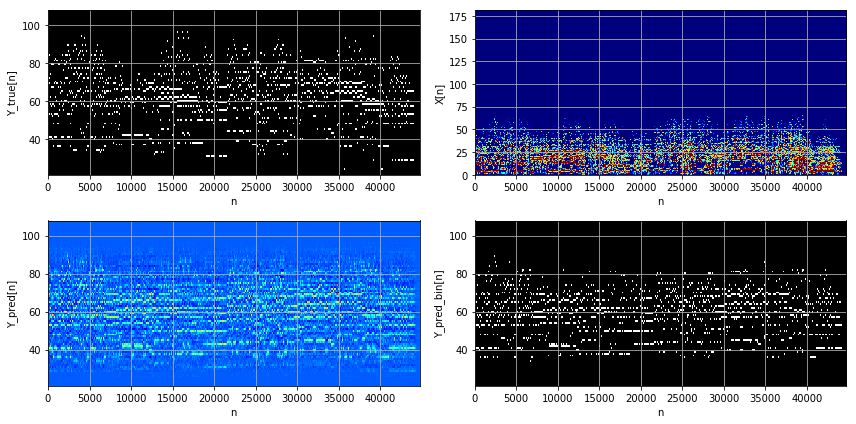

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].imshow(Y_true_train[0].T, origin='lower', vmin=0, vmax=1, cmap='gray', aspect='auto')
axs[0, 0].set_xlabel('n')
axs[0, 0].set_ylabel('Y_true[n]')
axs[0, 0].grid()
axs[0, 0].set_ylim([21, 108])

axs[0, 1].imshow(X_train[0].T, origin='lower', vmin=0, vmax=1, aspect='auto')
axs[0, 1].set_xlabel('n')
axs[0, 1].set_ylabel('X[n]')
axs[0, 1].grid()

im = axs[1, 0].imshow(Y_pred_train[0].T, origin='lower', aspect='auto')
axs[1, 0].set_xlabel('n')
axs[1, 0].set_ylabel('Y_pred[n]')
axs[1, 0].grid()
axs[1, 0].set_ylim([21, 108])
# fig.colorbar(im, ax=axs[1, 0])

axs[1, 1].imshow(Y_pred_bin_train[0].T, origin='lower', vmin=0, vmax=1, cmap='gray', aspect='auto')
axs[1, 1].set_xlabel('n')
axs[1, 1].set_ylabel('Y_pred_bin[n]')
axs[1, 1].grid()
axs[1, 1].set_ylim([21, 108])

plt.tight_layout()